## TabNet 

### Parameters

+ n_d: width decision predition layer[8,64], 
+ n_a:width attention [8,64], 
+ n_steps: steps in the architecture [3,10], 
+ gamma: coefficiente for feature reuse [1,2], close to 1 least corrlated default 1.3,
+ n_independent [1,5]: number of independent gated linear units, 2
+ n_shared [1,5], 2, 
+ epsilon=1e-15, 
+ momentum:0.01 to 0.4, default 0.02
+ lambda_sparse, seed, clip_value, verbose

In [53]:
# importing necessary libraries
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

import os

#TabNet librariees
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

## hyperparameters bayesian optimization
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK

import warnings
warnings.filterwarnings('ignore')

#https://www.kaggle.com/code/enigmak/tabnet-deep-neural-network-for-tabular-data



## Experiments with Gesture Dataset

----

In [58]:
## Preprocessing
base_path = 'homeworks/data/project/gesture_phase/'

# Load the data
df = pd.read_csv(base_path + 'gesture_phase.csv')


## Select features and target
X = df.values[:, :-1]
y_target = df.values[:, -1]
le = LabelEncoder()
y = le.fit_transform(y_target)


## Standarize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

## Splitting the data

X_train_val, X_test, y_train_val, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)

## Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)



In [82]:
num_clases =len(np.unique(y_train))
print(num_clases)

print(np.unique(y_test),np.unique(y_train),np.unique(y_val))

5
[0 1 2 3 4] [0 1 2 3 4] [0 1 2 3 4]


In [101]:
tabnet_clf = TabNetClassifier()
# Entrenar el modelo
tabnet_clf.fit(X_train, y_train, max_epochs=100, patience=10, batch_size=256, virtual_batch_size=128,num_workers=0)

epoch 0  | loss: 1.6004  |  0:00:00s
epoch 1  | loss: 1.44446 |  0:00:00s
epoch 2  | loss: 1.38468 |  0:00:01s
epoch 3  | loss: 1.35008 |  0:00:01s
epoch 4  | loss: 1.3175  |  0:00:01s
epoch 5  | loss: 1.30777 |  0:00:02s
epoch 6  | loss: 1.28891 |  0:00:02s
epoch 7  | loss: 1.27964 |  0:00:02s
epoch 8  | loss: 1.26798 |  0:00:03s
epoch 9  | loss: 1.27251 |  0:00:03s
epoch 10 | loss: 1.26128 |  0:00:03s
epoch 11 | loss: 1.26056 |  0:00:04s
epoch 12 | loss: 1.25521 |  0:00:04s
epoch 13 | loss: 1.25925 |  0:00:04s
epoch 14 | loss: 1.25473 |  0:00:05s
epoch 15 | loss: 1.24919 |  0:00:05s
epoch 16 | loss: 1.24625 |  0:00:05s
epoch 17 | loss: 1.24245 |  0:00:06s
epoch 18 | loss: 1.24274 |  0:00:06s
epoch 19 | loss: 1.24413 |  0:00:06s
epoch 20 | loss: 1.23443 |  0:00:07s
epoch 21 | loss: 1.23507 |  0:00:07s
epoch 22 | loss: 1.23677 |  0:00:07s
epoch 23 | loss: 1.23518 |  0:00:08s
epoch 24 | loss: 1.23051 |  0:00:08s
epoch 25 | loss: 1.23017 |  0:00:08s
epoch 26 | loss: 1.22678 |  0:00:09s
e

In [98]:
### Hyperparameters Tuning
"""
space = {
    'n_d': hp.choice('n_d', range(1, 64)),
    'n_a': hp.choice('n_a', range(1, 64)),
    'n_steps': hp.choice('n_steps', range(1, 10)),
    'gamma': hp.uniform('gamma', 1.0, 2.0),
    'n_independent': hp.choice('n_independent', range(1, 10)),
    'n_shared': hp.choice('n_shared', range(1, 10)),
    'lambda_sparse': hp.loguniform('lambda_sparse', -5, 0),
    'optimizer_params': {
        'lr': hp.loguniform('lr', -5, 0),
        'weight_decay': hp.loguniform('weight_decay', -5, 0)
    },
    'max_epochs': 50,
    'patience': 10,
    'batch_size': 256,
    'virtual_batch_size': 128
}

def objective(params):
    model = TabNetClassifier(
        n_d=int(params['n_d']),
        n_a=int(params['n_a']),
        n_steps=int(params['n_steps']),
        gamma=params['gamma'],
        n_independent=int(params['n_independent']),
        n_shared=int(params['n_shared']),
        lambda_sparse=params['lambda_sparse'],
        optimizer_params=params['optimizer_params'],
        output_dim=5,
       
       
    )
    model.fit(X_train, y_train, max_epochs=params['max_epochs'], 
    patience=params['patience'], batch_size=params['batch_size'],
    #eval_set=[(X_val, y_val)],   # Aquí se especifica el conjunto de validación
    #eval_name=['val'],
     virtual_batch_size=params['virtual_batch_size'], num_workers=0)
    labels = np.unique(y_train )
    preds = model.predict(X_test)
    
    y_probas = model.predict_proba(X_test)

    loss = log_loss(y_test, y_probas)
    y_pred_classes = np.argmax(y_probas, axis=1)
    print("Clases predichas en el conjunto de validación:", np.unique(y_pred_classes))
    # Calcula la métrica de evaluación, asegurando que las etiquetas estén bien definidas
    #accuracy = accuracy_score(y_val, y_pred)
    #report = classification_report(y_val, y_pred, labels=labels, output_dict=True)
    loss = log_loss(y_test, preds)
    return {'loss': loss, 'status': STATUS_OK}
""""

In [99]:
#trials = Trials()
#best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

epoch 0  | loss: 2.32689 |  0:00:02s                  
epoch 1  | loss: 1.6474  |  0:00:04s                  
epoch 2  | loss: 1.54464 |  0:00:06s                  
epoch 3  | loss: 1.52023 |  0:00:08s                  
epoch 4  | loss: 1.51504 |  0:00:10s                  
epoch 5  | loss: 1.50143 |  0:00:12s                  
epoch 6  | loss: 1.51093 |  0:00:15s                  
epoch 7  | loss: 1.50339 |  0:00:18s                  
epoch 8  | loss: 1.50164 |  0:00:20s                  
epoch 9  | loss: 1.49769 |  0:00:23s                  
epoch 10 | loss: 1.50238 |  0:00:26s                  
epoch 11 | loss: 1.49635 |  0:00:30s                  
epoch 12 | loss: 1.50393 |  0:00:37s                  
epoch 13 | loss: 1.49692 |  0:00:44s                  
epoch 14 | loss: 1.49815 |  0:00:52s                  
epoch 15 | loss: 1.50568 |  0:01:01s                  
epoch 16 | loss: 1.49621 |  0:01:10s                  
epoch 17 | loss: 1.5298  |  0:01:20s                  
epoch 18 |

job exception: y_true and y_pred contain different number of classes 5, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 1 2 3 4]



  0%|          | 0/10 [05:22<?, ?trial/s, best loss=?]


ValueError: y_true and y_pred contain different number of classes 5, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 1 2 3 4]

In [102]:
## Evaluation of the model

y_pred = tabnet_clf.predict(X_test)
y_proba = tabnet_clf.predict_proba(X_test)
loss = log_loss(y_test, y_proba)
print('Log Loss:', loss)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classfication Report:', classification_report(y_test, y_pred))

Log Loss: 1.2185115778588016
Accuracy: 0.5027848101265823
Classfication Report:               precision    recall  f1-score   support

           0       0.54      0.83      0.65       551
           1       0.22      0.02      0.04       197
           2       0.43      0.56      0.49       418
           3       0.46      0.32      0.38       215
           4       0.56      0.39      0.46       594

    accuracy                           0.50      1975
   macro avg       0.44      0.42      0.40      1975
weighted avg       0.48      0.50      0.47      1975



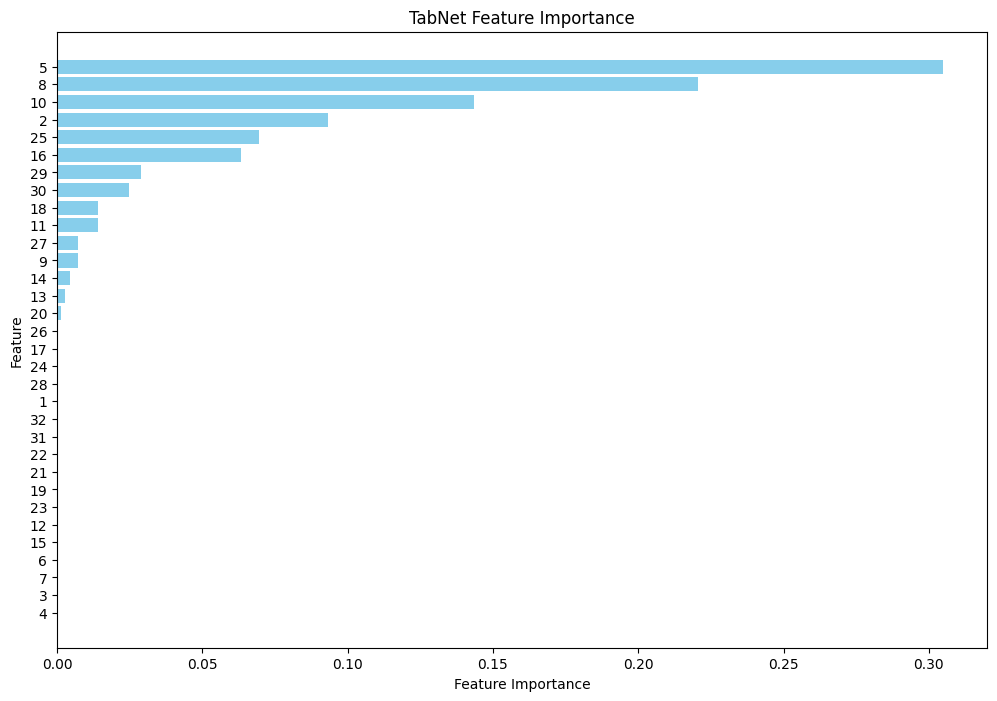

In [106]:
## Feature importance
importances = tabnet_clf.feature_importances_
features = df.columns[:-1]  # Suponiendo que la última columna es el target

# Ordenar las importancias y los nombres de las características
indices = np.argsort(importances)
sorted_importances = importances[indices]
sorted_features = features[indices]

plt.figure(figsize=(12, 8))
plt.barh(range(X.shape[1]), sorted_importances, color='skyblue')
plt.yticks(range(X.shape[1]), sorted_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('TabNet Feature Importance')
plt.savefig('feature_importance_tabnet.png')
plt.show()

In [46]:
y_pred = tabnet_clf.predict(X_test)
y_proba = tabnet_clf.predict_proba(X_test)
loss = log_loss(y_test, y_proba)
print('Log Loss:', loss)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classfication Report:', classification_report(y_test, y_pred))

Log Loss: 1.2185115778588016
Accuracy: 0.5027848101265823
Classfication Report:               precision    recall  f1-score   support

           0       0.54      0.83      0.65       551
           1       0.22      0.02      0.04       197
           2       0.43      0.56      0.49       418
           3       0.46      0.32      0.38       215
           4       0.56      0.39      0.46       594

    accuracy                           0.50      1975
   macro avg       0.44      0.42      0.40      1975
weighted avg       0.48      0.50      0.47      1975



## Experiments Forest Cover Type
----

In [108]:
base_pah = 'homeworks/data/project/'
df_forest = pd.read_csv(base_pah + 'forest_cover.csv')

In [109]:
df_forest.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [110]:
df_forest = df_forest.drop('Id', axis=1)
df_forest = df_forest.dropna()
X=df_forest.drop('Cover_Type', axis=1)
y=df_forest['Cover_Type']


X = df_forest.values[:, :-1]
y_target = df_forest.values[:, -1]
# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the data
y = le.fit_transform(y_target)

scaler = StandardScaler()

# Ajustar y transformar los datos
X_standardized = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X_standardized, y, test_size=0.3, random_state=42)

# Dividir el resto en validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

In [111]:
# Crear el modelo TabNetClassifier
tabnet_clf = TabNetClassifier()

# Entrenar el modelo
tabnet_clf.fit(X_train, y_train, max_epochs=100, patience=10, batch_size=256, virtual_batch_size=128)


epoch 0  | loss: 1.64072 |  0:00:00s
epoch 1  | loss: 1.06819 |  0:00:01s
epoch 2  | loss: 0.95204 |  0:00:01s
epoch 3  | loss: 0.90292 |  0:00:02s
epoch 4  | loss: 0.86034 |  0:00:02s
epoch 5  | loss: 0.84085 |  0:00:03s
epoch 6  | loss: 0.79502 |  0:00:04s
epoch 7  | loss: 0.77066 |  0:00:04s
epoch 8  | loss: 0.75043 |  0:00:05s
epoch 9  | loss: 0.74447 |  0:00:05s
epoch 10 | loss: 0.7439  |  0:00:06s
epoch 11 | loss: 0.72343 |  0:00:07s
epoch 12 | loss: 0.70218 |  0:00:07s
epoch 13 | loss: 0.68285 |  0:00:08s
epoch 14 | loss: 0.68476 |  0:00:08s
epoch 15 | loss: 0.66305 |  0:00:09s
epoch 16 | loss: 0.66326 |  0:00:10s
epoch 17 | loss: 0.65553 |  0:00:10s
epoch 18 | loss: 0.64123 |  0:00:11s
epoch 19 | loss: 0.64581 |  0:00:11s
epoch 20 | loss: 0.63244 |  0:00:12s
epoch 21 | loss: 0.6273  |  0:00:13s
epoch 22 | loss: 0.62003 |  0:00:13s
epoch 23 | loss: 0.62392 |  0:00:14s
epoch 24 | loss: 0.6114  |  0:00:14s
epoch 25 | loss: 0.60137 |  0:00:15s
epoch 26 | loss: 0.62584 |  0:00:16s
e

In [112]:
# Realizar predicciones en el conjunto de prueba
y_pred = tabnet_clf.predict(X_test)
y_proba = tabnet_clf.predict_proba(X_test)
loss = log_loss(y_test, y_proba)
print('Log Loss:', loss)


Log Loss: 0.5029583309231057


In [114]:
# Generar el informe de clasificación
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.77      0.58      0.66       409
           1       0.68      0.72      0.70       459
           2       0.78      0.72      0.75       435
           3       0.93      0.95      0.94       437
           4       0.85      0.90      0.88       430
           5       0.74      0.83      0.79       416
           6       0.92      0.97      0.94       438

    accuracy                           0.81      3024
   macro avg       0.81      0.81      0.81      3024
weighted avg       0.81      0.81      0.81      3024



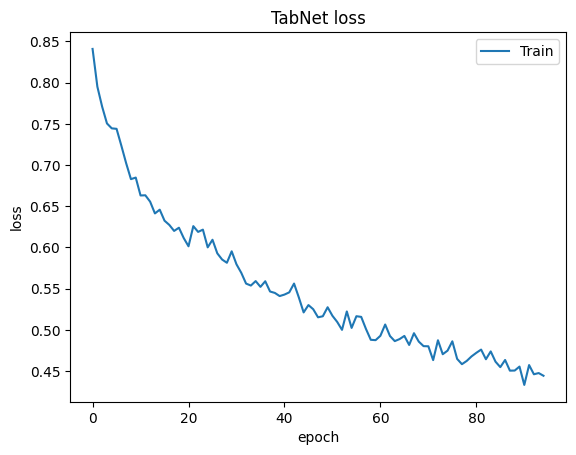

In [39]:
from matplotlib import pyplot as plt

plt.plot(tabnet_clf.history['loss'][5:], label='Train')
#plt.plot(tabnet_clf.history['val_0_logloss'][5:], label='Validation')
plt.title('TabNet loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('loss_curve_covertype_tabnet.png')
plt.show()

In [41]:
report = classification_report(y_true=y_test, y_pred=tabnet_clf.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.77      0.58      0.66       409
           1       0.68      0.72      0.70       459
           2       0.78      0.72      0.75       435
           3       0.93      0.95      0.94       437
           4       0.85      0.90      0.88       430
           5       0.74      0.83      0.79       416
           6       0.92      0.97      0.94       438

    accuracy                           0.81      3024
   macro avg       0.81      0.81      0.81      3024
weighted avg       0.81      0.81      0.81      3024



## Experiments with Shrutime


In [116]:
## Preprocessing
base_path = 'homeworks/data/project/'
df = pd.read_csv(base_path + 'shrutime_encoded.csv')
X = df.values[:, :-1]
y_target = df.values[:, -1]
# Initialize the LabelEncoder
le = LabelEncoder()
# Fit and transform the data
y = le.fit_transform(y_target)


scaler = StandardScaler()

X_standardized = scaler.fit_transform(X)

## Splitting the data

X_train_val, X_test, y_train_val, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)

## Split into train and validation sets

# Paso 2: Dividir el 80% de entrenamiento + validación en 70% entrenamiento y 10% validación
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)


In [117]:
clf = TabNetClassifier(n_d=6, n_a=6,epsilon=0.01,n_steps=8,seed=42,verbose=1,)  
clf.fit(
  X_train, y_train,
  eval_set=[(X_val, y_val)],
   patience=10,
    batch_size=256,
    virtual_batch_size=128,
    eval_metric=["logloss"]
)
preds = clf.predict(X_test)

epoch 0  | loss: 0.59866 | val_0_logloss: 0.47418 |  0:00:00s
epoch 1  | loss: 0.47193 | val_0_logloss: 0.47444 |  0:00:01s
epoch 2  | loss: 0.44447 | val_0_logloss: 0.44857 |  0:00:02s
epoch 3  | loss: 0.41925 | val_0_logloss: 0.36928 |  0:00:02s
epoch 4  | loss: 0.40727 | val_0_logloss: 0.37969 |  0:00:03s
epoch 5  | loss: 0.38251 | val_0_logloss: 0.35643 |  0:00:04s
epoch 6  | loss: 0.37855 | val_0_logloss: 0.3434  |  0:00:05s
epoch 7  | loss: 0.37958 | val_0_logloss: 0.3383  |  0:00:06s
epoch 8  | loss: 0.37099 | val_0_logloss: 0.33982 |  0:00:07s
epoch 9  | loss: 0.37424 | val_0_logloss: 0.35694 |  0:00:07s
epoch 10 | loss: 0.37252 | val_0_logloss: 0.35158 |  0:00:08s
epoch 11 | loss: 0.36677 | val_0_logloss: 0.34469 |  0:00:09s
epoch 12 | loss: 0.36289 | val_0_logloss: 0.3448  |  0:00:10s
epoch 13 | loss: 0.36351 | val_0_logloss: 0.36261 |  0:00:10s
epoch 14 | loss: 0.36686 | val_0_logloss: 0.34023 |  0:00:11s
epoch 15 | loss: 0.36277 | val_0_logloss: 0.35037 |  0:00:12s
epoch 16

In [119]:
report = classification_report(y_true=y_test, y_pred=preds)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1607
           1       0.69      0.49      0.57       393

    accuracy                           0.86      2000
   macro avg       0.79      0.72      0.74      2000
weighted avg       0.85      0.86      0.85      2000

